# 1. Sobre o projeto

Tópicos para entender os problemas do negócio

1. Motivação:
- Qual é o contexto?
- A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas

2. A causa raiz do problema
- Por que fazer uma previsão de vendas?
Dificuldade em determinar o valor do investimento para reformas de cada loja

3. Quem é o dono do problema
- Quem será o stakeholder?
Diretor Financeiro (CFO) da Rossmann

4. O formato da solução
- Qual o formato da solução?
  - Granularidade: Previsão de vendas por dia por loja para as próximas 42 dias, 6 semanas
  - Tipo de problema: Previsão de vendas
  - Potenciais métodos: Séries temporais
  - Formato da entrega: 
  1. O Valor total das vendas no final de 6 semanas por loja
  2. Poder acompanhar pelo celular 
  
Escrever

### 1.1. Contexto do Problema de Negócio

### 1.2. O Desafio

Formato da solução
- Vendas diárias em R$, nas próximas 6 semanas
- Problemas de predição
- Time series, regressão e neural network
- Predição acessadas via celular

# 2. Entendimento e preparação dos dados

### 2.1. Exportar os dados da fonte

### 2.2. Importar os dados e as bibliotecas

In [5]:
#!pip install inflection

In [36]:
import inflection
import math

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

In [7]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [8]:
df = df_raw.copy()
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 3. Análise e modelagem

### 3.1. Análise exploratória

In [9]:
# Verifica NA's
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [10]:
# Verifica tipos de dados
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [11]:
df.sample(5).T

,270936,395661,699519,657915,21111
Store,1070,394,85,851,1042
DayOfWeek,2,1,6,2,1
Date,2014-11-25,2014-07-14,2013-10-12,2013-11-19,2015-07-13
Sales,7669,10021,5272,5530,5200
Customers,882,706,727,469,576
Open,1,1,1,1,1
Promo,1,1,0,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,1
StoreType,c,d,b,d,a


### 3.2. Tratamento e preparação dos dados

#### 3.2.1. Funções 

In [12]:
# Função para renomear as colunas do dataframe
def rename_columns(df_aux):
#    df_aux = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df_aux.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df_aux.columns = cols_new
    return df_aux    

#### 3.2.2. Limpeza, preenchimento e modificação dos dados

Fill NA's

- competition_distance 2642 (NA's) | max = 75860.0
- CompetitionDistance - distance in meters to the nearest competitor store
- Considerando a hipótese de que os NA's desse campo significam que não há concorrência próxima
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- competition_open_since_month    323348
- competition_open_since_year     323348
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- promo2_since_week               508031
- promo2_since_year               508031
- promo_interval                  508031
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. # E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [13]:
# Modifica os nomes das colunas
df = rename_columns(df)

# Modifica 'date' para o formato datetime
df['date'] =  pd.to_datetime(df['date'])

In [14]:
# Preenche a coluna competition_distance
df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# Preenche a coluna competition_open_since_month
df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# Preenche a coluna competition_open_since_year
df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# Preenche a coluna promo2_since_week
df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# Preenche a coluna promo2_since_year
df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# Preenche a coluna promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df['promo_interval'].fillna(0, inplace=True)
df['month_map'] = df['date'].dt.month.map(month_map)

df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
# Modifica 'competition_open_since_month' para o formato int
df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)

# Modifica 'competition_open_since_year' para o formato int
df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)

# Modifica 'promo2_since_week' para o formato int
df['promo2_since_week'] = df['promo2_since_week'].astype(int)

# Modifica 'promo2_since_year' para o formato int
df['promo2_since_year'] = df['promo2_since_year'].astype(int)

In [16]:
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


### 3.3. Estatística descritiva

Por que é importante? Para ganhar conhecimento de negócio e detectar alguns erros através do comportamento das:
- Métricas de tendência central: média, mediana e moda.
- Métricas de dispersão: amplitude, desvio, variância e desvio padrão.
  - Skew: a deformação em relação a curvatura normal 
  - Kurtosis: concentração dos dados (quanto maior a altura do pico, maior a concentração dos dados,  um pico menor dignifica dados mais dispersos)

In [17]:
# Separar variáveis numéricas de variáveis categóricas

num_attributes = df.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])


#### 3.3.1. Numerical attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

# Renomear colunas
m.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.171835,0.0,0.377237,1.739838,1.027039


In [19]:
# num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T

# num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

# Pra incluir o 'range', podemos utilizar a função 'ptp' (Peak-to-PeaK)
# num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})



C:\Users\paula\AppData\Local\Temp\ipykernel_6952\3512468984.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df['sales'] )


<AxesSubplot: xlabel='sales', ylabel='Density'>

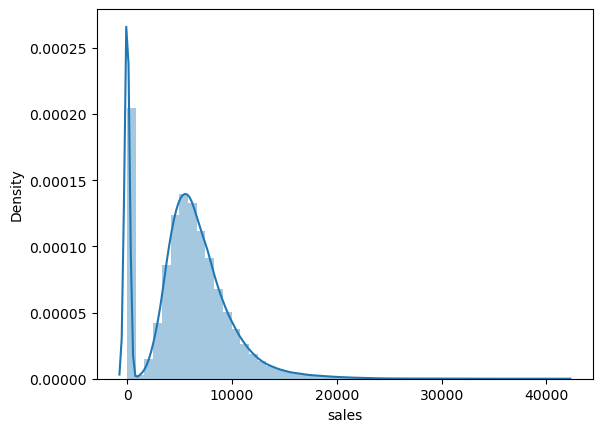

In [20]:
sns.distplot( df['sales'] )

#### 3.3.2. Categorical attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot: xlabel='state_holiday', ylabel='sales'>

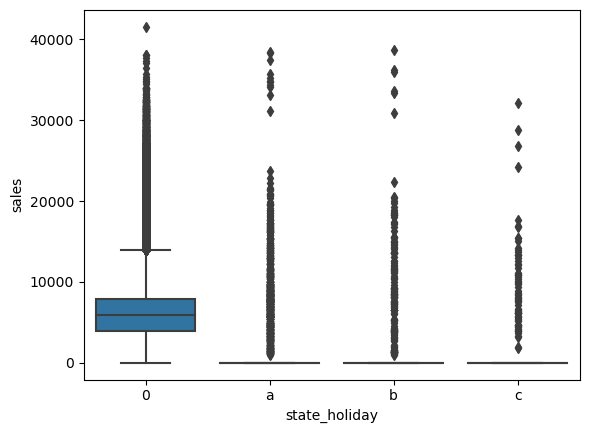

In [22]:
sns.boxplot( x='state_holiday', y='sales', data=df )
# É impossível enxergar com o boxplot nessas dimensões

<AxesSubplot: xlabel='state_holiday', ylabel='sales'>

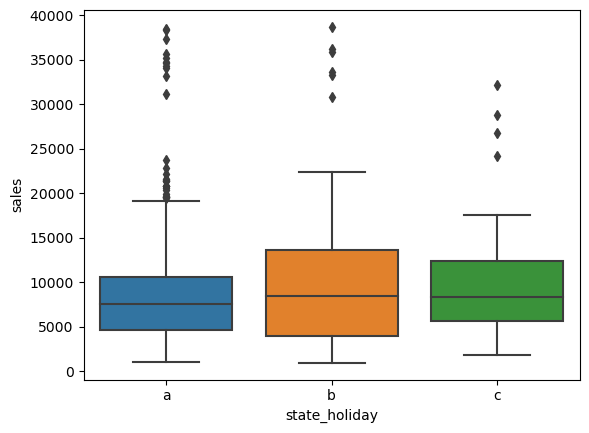

In [24]:
aux = df[((df['state_holiday'] != '0') & (df['sales'] > 0))]
sns.boxplot(x='state_holiday', y='sales', data=aux)

"\nplt.subplot(1, 3, 1)\nsns.boxplot(x='state_holiday', y='sales', data=aux)\n\nplt.subplot(1, 3, 2)\nsns.boxplot(x='store_type', y='sales', data=aux)\n\nplt.subplot(1, 3, 3)\nsns.boxplot(x='assortment', y='sales', data=aux)\n\nplt.subplots_adjust(wspace=0.5)  # define o espaço horizontal entre as colunas"

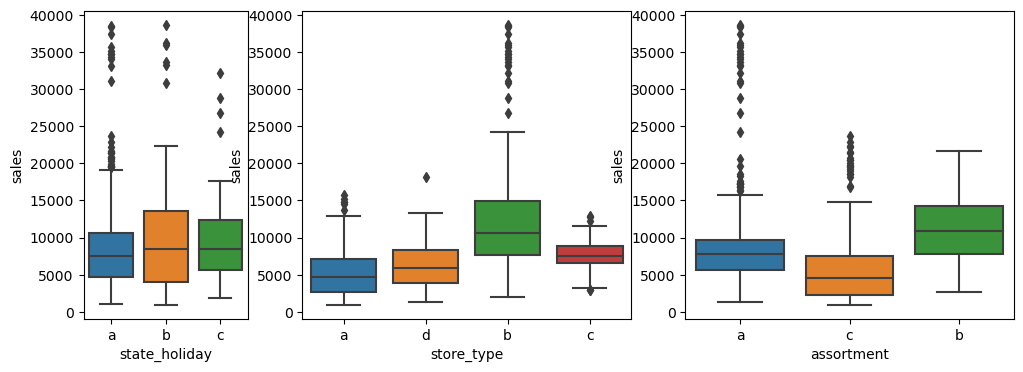

In [35]:
aux = df[((df['state_holiday'] != '0') & (df['sales'] > 0))]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), width_ratios=[0.5, 1, 1])

sns.boxplot(x='state_holiday', y='sales', data=aux, ax=axs[0])
sns.boxplot(x='store_type', y='sales', data=aux, ax=axs[1])
sns.boxplot(x='assortment', y='sales', data=aux, ax=axs[2])

'''
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

plt.subplots_adjust(wspace=0.5)  # define o espaço horizontal entre as colunas'''

In [ ]:
# "min" nao è o valor mìnimo e sim = Q1-1.5* (Q3-Q1)
# "max" nao è o valor màximo e sim = Q3+1.5 *(Q3-Q1)
# outliers 3x o desvio padrão std
# Distribuição x Concentração 

### 3.4. Definição do modelo

### 3.5. Feature Engineering

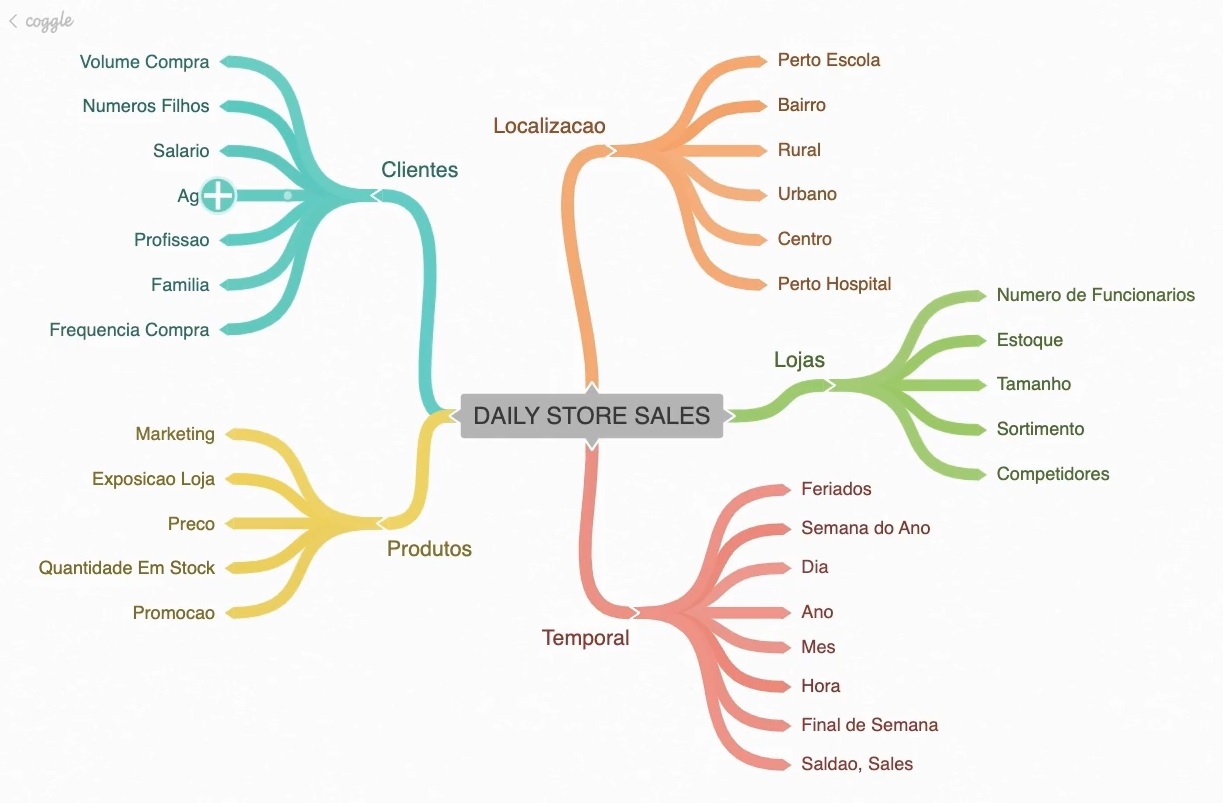

In [38]:
Image('../img/MindMapHypothesis.jpg')

Criação de hipóteses

1. Hipóteses Loja:
- Lojas com maior sortimento deveriam vender mais;
- Lojas com competidores mais próximos deveriam vender menos;
- Lojas com competidores à mais tempo deveriam vender mais.

2. Hipóteses Produto:
- Lojas com promoções ativas deveriam vender mais;
- Lojas com mais dias de promoção deveriam vender mais;
- Lojas com mais promoções consecutivas deveriam vender mais.

3. Hipóteses Tempo
- Lojas abertas durante o feriado de Natal deveriam vender mais;
- Lojas deveriam vender mais ao longo dos anos;
- Lojas deveriam vender mais no segundo semestre do ano;
- Lojas deveriam vender mais depois do dia 10 de cada mês;
- Lojas deveriam vender menos aos finais de semana;
- Lojas deveriam vender menos durante os feriados escolares.

In [39]:
df1 = df.copy()

In [ ]:
# year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

# day
df1['day'] = df1['date'].dt.day

# week of year
df1['week_of_year'] = df1['date'].dt.weekofyear

# year week
df1['year_week'] = df1['date'].dt.strftime( '%Y-%W' )

# competition since
df1.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1 ), axis=1 )

# Promo since
# assortment
# state holiday

In [40]:
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

# 4. Validação do modelo

### 4.1. O modelo

### 4.2. Métrica

### 4.3. Comparação

# 5. Preparação e visualização

### 5.1. Apresentação

#### 5.1.1. O resultado corresponde com o esperado?

#### 5.1.2. É necessário algum ajuste?

### 5.2. Pode ser implementado?

# 6. Implementação